In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
import datetime
import gc
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from sklearn.model_selection import train_test_split,KFold,GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

In [3]:
metadata_dtype = {'site_id':"uint8",'building_id':'uint16','square_feet':'float32','year_built':'float32','floor_count':"float16"}
metadata = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv",dtype=metadata_dtype)
metadata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null uint8
building_id    1449 non-null uint16
primary_use    1449 non-null object
square_feet    1449 non-null float32
year_built     675 non-null float32
floor_count    355 non-null float16
dtypes: float16(1), float32(2), object(1), uint16(1), uint8(1)
memory usage: 117.3 KB


In [4]:
weather_dtype = {"site_id":"uint8"}
weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv",parse_dates=['timestamp'],dtype=weather_dtype)
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv",parse_dates=['timestamp'],dtype=weather_dtype)
print (weather_train.info(memory_usage='deep'))
print ("-------------------------------------")
print (weather_test.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), uint8(1)
memory usage: 8.7 MB
None
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null uint8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_h

In [5]:
train_dtype = {'meter':"uint8",'building_id':'uint16','meter_reading':"float32"}
train = pd.read_csv("../input/ashrae-energy-prediction/train.csv",parse_dates=['timestamp'],dtype=train_dtype)
test_dtype = {'meter':"uint8",'building_id':'uint16'}
test_cols_to_read = ['building_id','meter','timestamp']
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv",parse_dates=['timestamp'],usecols=test_cols_to_read,dtype=test_dtype)

In [6]:
Submission = pd.DataFrame(test.index,columns=['row_id'])

In [7]:
train.tail(20)

,building_id,meter,timestamp,meter_reading
20216080,1434,0,2016-12-31 23:00:00,70.72500
20216081,1434,2,2016-12-31 23:00:00,259.07300
20216082,1435,0,2016-12-31 23:00:00,4.72500
20216083,1436,0,2016-12-31 23:00:00,11.60000
20216084,1436,2,2016-12-31 23:00:00,1274.66003
20216085,1437,0,2016-12-31 23:00:00,195.92500
20216086,1437,2,2016-12-31 23:00:00,1518.92004
20216087,1438,0,2016-12-31 23:00:00,100.67500
20216088,1438,2,2016-12-31 23:00:00,852.77002
20216089,1439,0,2016-12-31 23:00:00,167.39999


In [8]:
test.head()

,building_id,meter,timestamp
0,0,0,2017-01-01
1,1,0,2017-01-01
2,2,0,2017-01-01
3,3,0,2017-01-01
4,4,0,2017-01-01


In [9]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432.00000,2008.00000,nan
1,0,1,Education,2720.00000,2004.00000,nan
2,0,2,Education,5376.00000,1991.00000,nan
3,0,3,Education,23685.00000,2002.00000,nan
4,0,4,Education,116607.00000,1975.00000,nan


In [10]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.00000,6.00000,20.00000,nan,1019.70000,0.00000,0.00000
1,0,2016-01-01 01:00:00,24.40000,nan,21.10000,-1.00000,1020.20000,70.00000,1.50000
2,0,2016-01-01 02:00:00,22.80000,2.00000,21.10000,0.00000,1020.20000,0.00000,0.00000
3,0,2016-01-01 03:00:00,21.10000,2.00000,20.60000,0.00000,1020.10000,0.00000,0.00000
4,0,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.60000


In [11]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.80000,4.00000,11.70000,nan,1021.40000,100.00000,3.60000
1,0,2017-01-01 01:00:00,17.80000,2.00000,12.80000,0.00000,1022.00000,130.00000,3.10000
2,0,2017-01-01 02:00:00,16.10000,0.00000,12.80000,0.00000,1021.90000,140.00000,3.10000
3,0,2017-01-01 03:00:00,17.20000,0.00000,13.30000,0.00000,1022.20000,140.00000,3.10000
4,0,2017-01-01 04:00:00,16.70000,2.00000,13.30000,0.00000,1022.30000,130.00000,2.60000


### Missing Values

In [12]:
missing_weather = pd.DataFrame(weather_train.isna().sum()/len(weather_train),columns=["Weather_Train_Missing_Pct"])
missing_weather["Weather_Test_Missing_Pct"] = weather_test.isna().sum()/len(weather_test)
missing_weather

,Weather_Train_Missing_Pct,Weather_Test_Missing_Pct
site_id,0.00000,0.00000
timestamp,0.00000,0.00000
air_temperature,0.00039,0.00038
cloud_coverage,0.49490,0.50659
dew_temperature,0.00081,0.00118
precip_depth_1_hr,0.35979,0.34478
sea_level_pressure,0.07597,0.07670
wind_direction,0.04484,0.04462
wind_speed,0.00217,0.00166


1. precip_depth_1_hr variable has similar number of missing values in both train and test weather data.
2. cloud_coverage variable has similar number of missing values in both train and test weather data.
3. site_id and timestamp do not have missing values. Other variables have some missing values.

In [13]:
metadata.isna().sum()/len(metadata)

site_id       0.00000
building_id   0.00000
primary_use   0.00000
square_feet   0.00000
year_built    0.53416
floor_count   0.75500
dtype: float64

In [14]:
metadata['floor_count_isNa'] = metadata['floor_count'].isna().astype('uint8')
metadata['year_built_isNa'] = metadata['year_built'].isna().astype('uint8')
# Dropping floor_count variable as it has 75% missing values
metadata.drop('floor_count',axis=1,inplace=True)

1. year_built also has large number of missing columns.

In [15]:
missing_train_test = pd.DataFrame(train.isna().sum()/len(train),columns=["Missing_Pct_Train"])
missing_train_test["Missing_Pct_Test"] = test.isna().sum()/len(test)
missing_train_test

,Missing_Pct_Train,Missing_Pct_Test
building_id,0.00000,0.00000
meter,0.00000,0.00000
timestamp,0.00000,0.00000
meter_reading,0.00000,nan


1. No Missing values in train/test datasets.

### EDA- Train Data

In [16]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.00000
1,1,0,2016-01-01,0.00000
2,2,0,2016-01-01,0.00000
3,3,0,2016-01-01,0.00000
4,4,0,2016-01-01,0.00000


In [17]:
train.describe(include='all')
# Data contains records from 1st Jan to 31st Dec of 2016.
# Data has information about 1448 buildings.
# Data has 4 meter types.
# Some extremely high values in meter reading which can be explored further.

,building_id,meter,timestamp,meter_reading
count,20216100.00000,20216100.00000,20216100,20216100.00000
unique,nan,nan,8784,nan
top,nan,nan,2016-12-27 22:00:00,nan
freq,nan,nan,2370,nan
first,nan,nan,2016-01-01 00:00:00,nan
last,nan,nan,2016-12-31 23:00:00,nan
mean,799.27800,0.66244,NaN,1988.70618
std,426.91331,0.93099,NaN,153215.93750
min,0.00000,0.00000,NaN,0.00000
25%,393.00000,0.00000,NaN,18.30000


In [18]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

In [19]:
trace1 = go.Bar(x=train['meter'].unique(),y=train['meter'].value_counts().values,marker=dict(color="rgb(55, 83, 109)"),text='train')
trace2 = go.Bar(x=test['meter'].unique(),y=test['meter'].value_counts().values,marker=dict(color="blue"),text='test')
data=[trace1,trace2]
layout = go.Layout(title='Countplot of meter',xaxis=dict(title='Meter'),yaxis=dict(title='Count'),hovermode='closest')
figure = go.Figure(data=data,layout=layout)
iplot(figure)

In [20]:
print ("There are {} unique Buildings in the training data".format(train['building_id'].nunique()))

There are 1449 unique Buildings in the training data


In [21]:
train['building_id'].value_counts(dropna=False).head(20)

1298    35136
1249    35136
1301    35128
1241    35116
1296    35115
1297    35115
1295    35108
1294    35108
1259    35099
1232    34131
1293    33714
1258    31967
1331    29608
1094    26352
1260    26352
1254    26352
1252    26352
1251    26352
1262    26352
1263    26352
Name: building_id, dtype: int64

In [22]:
train[train['building_id'] == 1094]['meter'].unique()
# Like it is mentioned in the competition description, each building may or may not have all 4 meter Id codes.

array(['Electricity', 'ChilledWater', 'Steam'], dtype=object)

In [23]:
train.groupby('meter')['meter_reading'].agg(['min','max','mean','median','count','std'])
# We can see that Steam meter has some values that are very high maximum values, we have to explore further. 
# Minimum value for all 4 types of meter is 0.

,min,max,mean,median,count,std
meter,,,,,,
ChilledWater,0.00000,880374.00000,633.36395,120.48700,4182440,7988.21289
Electricity,0.00000,79769.00000,170.82564,62.83190,12060910,380.83429
HotWater,0.00000,160187.00000,385.86679,39.62370,1264037,2508.17261
Steam,0.00000,21904700.00000,13882.18750,257.81201,2708713,418313.50000


In [24]:
for df in [train, test]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

Text(0.5, 1.0, 'Graph of Average Meter Reading')

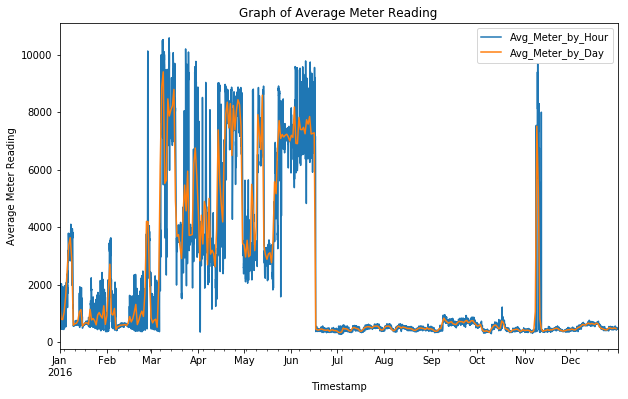

In [25]:
train[['timestamp','meter_reading']].set_index('timestamp').resample("H")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Hour')
train[['timestamp','meter_reading']].set_index('timestamp').resample("D")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Day')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Average Meter Reading")
plt.title("Graph of Average Meter Reading")
# We can see some surprising trends here, the meter reading is low from Jan to March, however from March it shoots up until mid June, then it almost reaches 0
# till Mid november and then briefly shoots up again and then drops to zero. 

Text(0.5, 1.0, 'Graph of Average Meter Readingfor Electricity Meter')

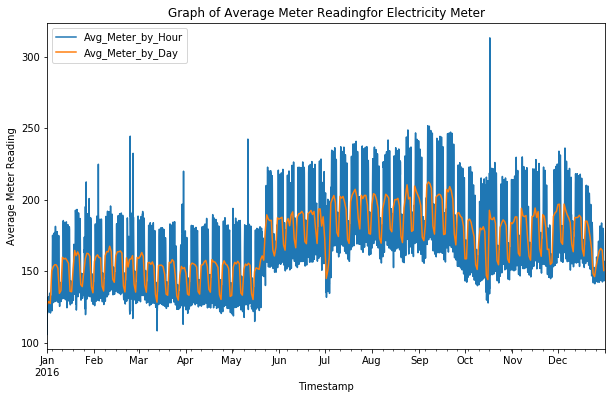

In [26]:
meter_Electricity = train[train['meter'] == "Electricity"]
meter_Electricity[['timestamp','meter_reading']].set_index('timestamp').resample("H")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Hour')
meter_Electricity[['timestamp','meter_reading']].set_index('timestamp').resample("D")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Day')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Average Meter Reading")
plt.title("Graph of Average Meter Readingfor Electricity Meter")
# The increase and decreasing trend can be attributed to the usage during the weekdays and during the weekends when it drops. 

Text(0.5, 1.0, 'Graph of Average Meter Readingfor ChilledWater Meter')

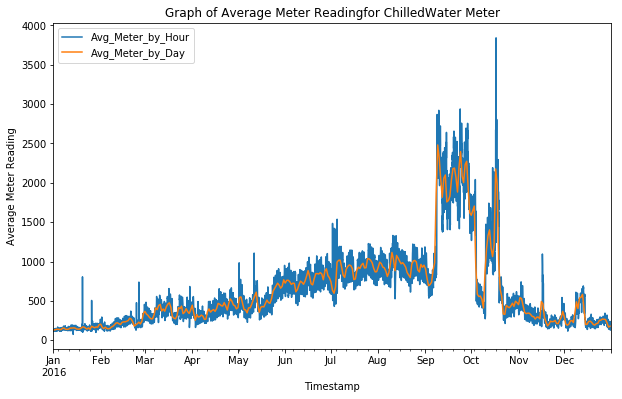

In [27]:
meter_ChilledWater = train[train['meter'] == "ChilledWater"]
meter_ChilledWater[['timestamp','meter_reading']].set_index('timestamp').resample("H")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Hour')
meter_ChilledWater[['timestamp','meter_reading']].set_index('timestamp').resample("D")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Day')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Average Meter Reading")
plt.title("Graph of Average Meter Readingfor ChilledWater Meter")
# Consumption gradually increases and reaches its peak during septembet to November months. 

Text(0.5, 1.0, 'Graph of Average Meter Readingfor Steam Meter')

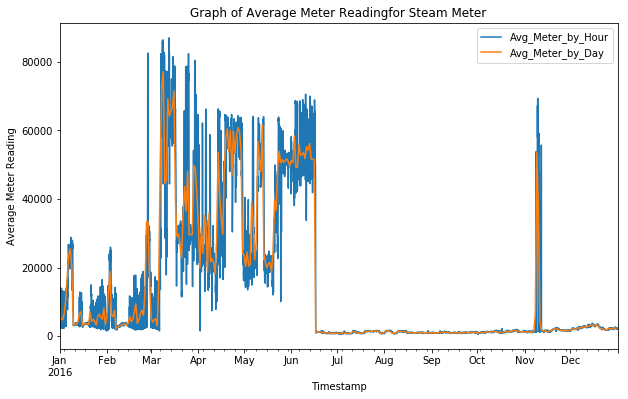

In [28]:
meter_Steam = train[train['meter'] == "Steam"]
meter_Steam[['timestamp','meter_reading']].set_index('timestamp').resample("H")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Hour')
meter_Steam[['timestamp','meter_reading']].set_index('timestamp').resample("D")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Day')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Average Meter Reading")
plt.title("Graph of Average Meter Readingfor Steam Meter")
# This is almost similar to that of the overall trend. 

Text(0.5, 1.0, 'Graph of Average Meter Readingfor HotWater Meter')

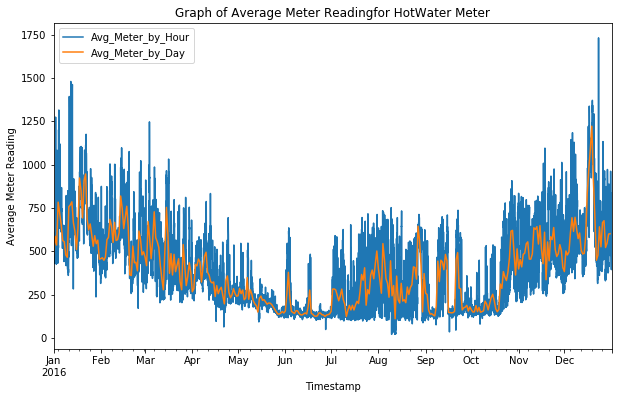

In [29]:
meter_HotWater = train[train['meter'] == "HotWater"]
meter_HotWater[['timestamp','meter_reading']].set_index('timestamp').resample("H")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Hour')
meter_HotWater[['timestamp','meter_reading']].set_index('timestamp').resample("D")['meter_reading'].mean().plot(kind='line',figsize=(10,6),label='Avg_Meter_by_Day')
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Average Meter Reading")
plt.title("Graph of Average Meter Readingfor HotWater Meter")
# Hot water meter reading is high during the winter months and reduces during the summer months. 

In [30]:
train.groupby(['meter','Month'])['meter_reading'].agg(['max','mean','median','count','std'])
# We can see that only Steam meter has very high meter_reading values as compared to other types of meters.
# We can see that the average electricity meter_reading does not vary much across the months.
# Average Hot Water meter_reading is relatively less from April to October Months.
# Average Steam meter_reading is way higher from March to June as compared to the other months.

max        mean    median    count          std
meter        Month                                                           
ChilledWater 1        28271.00000   151.19073  21.31210   337659    420.35205
             2        21601.59961   207.66978  47.31440   290218    465.15805
             3        47512.69922   366.86926  88.06190   321893    792.66675
             4        20793.50000   388.60706  96.29140   354758    838.58154
             5       172611.00000   519.05756 154.00301   367763   1115.18970
             6        29639.59961   772.16217 267.98401   356074   1540.70508
             7        85756.39844   892.34869 307.04050   367522   1890.97327
             8        70906.60156   943.69568 338.95401   352706   1943.70789
             9       880374.00000  1760.82715 263.79199   352182  23094.59961
             10      716997.00000   878.40564 121.08200   364181  13726.36914
             11      348495.00000   319.10464  71.14590   350925   1997.16992
             12      198488.00000   281.20450  29.36570   366559   3182.99414
Electricity  1        29431.00000   149.31276  54.25000  1031063    344.26514
             2        25275.00000   154.98007  55.95000   915638    358.88373
             3        44336.50000   149.32664  51.50000   958324    354.88586
             4         6468.85986   148.43819  53.05000  1001113    341.90866
             5         9402.00000   157.95413  55.98250  1033147    362.05878
             6         8876.00000   183.95909  67.93000  1001261    393.94855
             7        19511.00000   189.00237  69.90000  1027852    411.86414
             8        10295.00000   194.16162  74.75000  1024095    401.98538
             9         7894.89990   193.29575  74.58330  1007441    390.09741
             10       79769.00000   173.33757  64.19000  1037744    362.41382
             11       17502.09961   178.84216  68.68800  1002201    407.95453
             12       17999.00000   174.73732  65.58600  1021031    420.84802
HotWater     1       108799.00000   648.93774 146.53600   107028   2434.01685
             2        77125.10156   559.86847 115.97600    99444   2281.44482
             3       116081.00000   465.09598  70.33700   105596   2874.69458
             4        78669.00000   323.65878  46.89140   103779   1318.41150
             5        49371.89844   208.82651  23.34745   106502    732.97308
             6        72090.10156   159.80637   8.79210   103618   1028.67175
             7        87546.50000   261.02911   5.86140   107597   2540.12891
             8        89634.79688   327.35925   5.86140   107368   3410.67480
             9        86517.20312   254.68445   8.62615   104008   2431.00708
             10       80954.39844   273.95581  14.65360   107726   2029.32288
             11      112513.00000   513.34198  64.47560   104210   3292.19946
             12      160187.00000   638.18640  99.64410   107161   3634.61377
Steam        1      8243400.00000  7254.35938 698.24200   233100 145766.84375
             2     20392200.00000  8164.74951 532.70001   189600 195681.45312
             3     21724400.00000 39060.41406 332.93597   189590 720316.37500
             4     20413500.00000 39994.50781 317.91251   226686 757326.25000
             5     20032400.00000 36696.15234 180.59451   236032 696257.87500
             6     21904700.00000 28641.53320 109.80000   228299 681610.75000
             7       126750.00000  1056.98755  95.29124   236116   5802.60889
             8       131625.00000  1095.29822 107.43400   237016   5971.78613
             9       105000.00000  1002.11267 132.80350   230820   4182.91260
             10       74250.00000  1232.80200 207.39999   237698   4337.87354
             11    21847900.00000  4713.50635 378.20001   231688 229492.09375
             12      108000.00000  2440.21875 686.38000   232068   6269.00195

In [31]:
train.groupby(['meter','DayOfWeek'])['meter_reading'].agg(['max','mean','median','count','std'])
# Average meter_reading of Steam type of meter is higher as compared to the other meter types.

max        mean    median    count  \
meter        DayOfWeek                                                 
ChilledWater 0           793065.00000   649.26166 125.83300   595214   
             1           751685.00000   671.75262 132.28000   594969   
             2           849418.00000   652.51086 130.40500   594893   
             3           828374.00000   645.29193 133.44850   595478   
             4           880374.00000   633.13098 123.95000   606214   
             5           842194.00000   591.99866 101.81300   603938   
             6           740963.00000   589.97852 100.54700   591734   
Electricity  0            79769.00000   175.68622  65.27000  1711905   
             1            19511.00000   179.13466  67.65825  1714778   
             2            44336.50000   179.19997  67.60000  1715699   
             3            17999.00000   178.70992  67.48000  1715180   
             4            25275.00000   174.84210  65.04000  1745679   
             5            31921.00000   155.52113  55.29170  1746705   
             6            31921.00000   152.85989  53.80000  1710964   
HotWater     0           116191.00000   397.97437  41.60000   179537   
             1           109348.00000   384.96213  41.02990   179520   
             2           108594.00000   378.15366  40.11115   179648   
             3           116081.00000   386.00092  38.09920   179680   
             4           160187.00000   390.34723  39.20425   183026   
             5           106629.00000   384.11847  38.09920   183048   
             6           108894.00000   379.46387  38.09920   179578   
Steam        0         21904700.00000 12719.08301 265.35001   384571   
             1         21382500.00000 14937.29004 258.78900   384322   
             2         21847900.00000 16550.23438 259.25000   385848   
             3         21508500.00000 14908.27637 257.11499   385606   
             4         21889900.00000 14114.88867 265.35001   392299   
             5         21724400.00000 12137.56445 250.00000   392026   
             6         20629700.00000 11823.34375 246.69299   384041   

                                std  
meter        DayOfWeek               
ChilledWater 0           8312.48438  
             1           8489.06445  
             2           7700.23584  
             3           7529.12646  
             4           7951.39990  
             5           7959.58057  
             6           7935.34570  
Electricity  0            399.70551  
             1            399.70529  
             2            403.14294  
             3            398.82352  
             4            392.60440  
             5            333.59705  
             6            329.08661  
HotWater     0           2631.28003  
             1           2482.40771  
             2           2393.34180  
             3           2521.30542  
             4           2450.83008  
             5           2502.73877  
             6           2569.31836  
Steam        0         391956.40625  
             1         449612.34375  
             2         481477.28125  
             3         436376.71875  
             4         428203.81250  
             5         364885.78125  
             6         361567.40625

In [32]:
train.groupby('building_id')['meter_reading'].agg(['count','min','max','mean','median','std'])
# We can see that the values for building number 1099 are exceptionally high. These can be safely considered as outliers and can be dropped.

,count,min,max,mean,median,std
building_id,,,,,,
0,8784,0.00000,448.00000,146.45497,189.75200,121.89717
1,8784,0.00000,255.00000,74.86539,95.01240,61.76539
2,8784,0.00000,67.98300,14.55138,9.41930,16.06379
3,8784,0.00000,937.00000,235.54997,315.68399,205.98586
4,8784,0.00000,3592.00000,976.55676,1450.43994,779.69409
5,8784,0.00000,75.08160,17.89445,13.99250,18.80204
6,8784,0.00000,266.19901,64.06660,76.99280,57.40640
7,16051,0.00000,8442.07031,1593.89148,611.57397,1899.77832
8,8784,0.00000,749.00000,256.92780,365.51099,208.75874


In [33]:
train[train['building_id'] == 1099]['meter_reading'].describe()

count      17566.00000
mean     1907325.62500
std      4834749.50000
min          144.00000
25%          520.39099
50%          985.69699
75%         7008.00000
max     21904700.00000
Name: meter_reading, dtype: float64

(array([14664.,   322.,   478.,   538.,   117.,    77.,   281.,   535.,
          423.,   131.]),
 array([1.4400000e+02, 2.1905995e+06, 4.3810550e+06, 6.5715110e+06,
        8.7619660e+06, 1.0952422e+07, 1.3142878e+07, 1.5333333e+07,
        1.7523788e+07, 1.9714244e+07, 2.1904700e+07], dtype=float32),
 <a list of 10 Patch objects>)

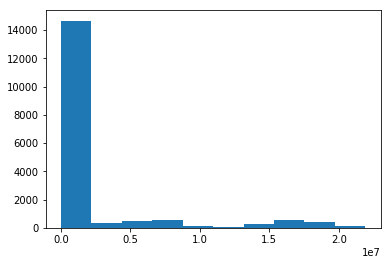

In [34]:
plt.hist(train[train['building_id'] == 1099]['meter_reading'])

In [35]:
train[(train['building_id'] == 1099) & (train['meter'] == "Steam")]['meter_reading'].describe()

count       8784.00000
mean     3813981.50000
std      6282386.50000
min          144.00000
25%         1608.00000
50%         7008.00000
75%      6340610.00000
max     21904700.00000
Name: meter_reading, dtype: float64

In [36]:
iqr = train[train['building_id'] == 1099]['meter_reading'].quantile(0.75)-train[train['building_id'] == 1099]['meter_reading'].quantile(0.25)
q3 = train[train['building_id'] == 1099]['meter_reading'].quantile(0.75)
q1 = train[train['building_id'] == 1099]['meter_reading'].quantile(0.25)

In [37]:
outlier_range_building_1099 = (q1-1.5*iqr,q3+1.5*iqr)
outlier_range_building_1099
# We can see that any value above 16739 can be considered as outlier

(-9211.022521972656, 16739.413513183594)

## Dependent Variable

In [38]:
train['meter_reading'].describe()

count   20216100.00000
mean        1988.70618
std       153215.93750
min            0.00000
25%           18.30000
50%           78.77500
75%          267.98401
max     21904700.00000
Name: meter_reading, dtype: float64

Text(0.5, 1.0, 'Distribution of Log of Meter Reading Variable')

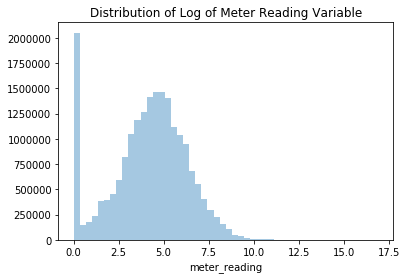

In [39]:
sns.distplot(np.log1p(train['meter_reading']),kde=False)
plt.title("Distribution of Log of Meter Reading Variable")
# Lot of 0 values as can be seen from the distribution

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: Electricity')

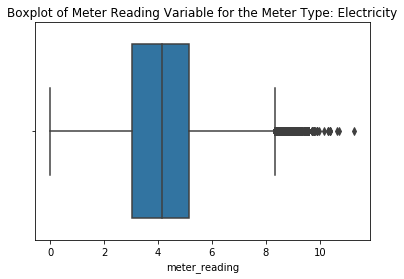

In [40]:
sns.boxplot(np.log1p(train[train['meter'] == "Electricity"]['meter_reading']))
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity")
# We can see a few outliers here.

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: Electricity')

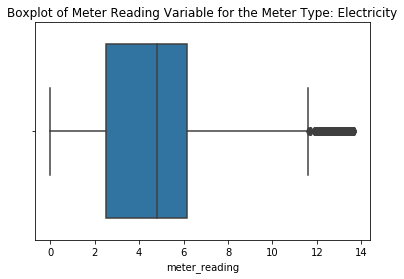

In [41]:
sns.boxplot(np.log1p(train[train['meter'] == "ChilledWater"]['meter_reading']))
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity")
# Not many outliers here. 

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: Electricity')

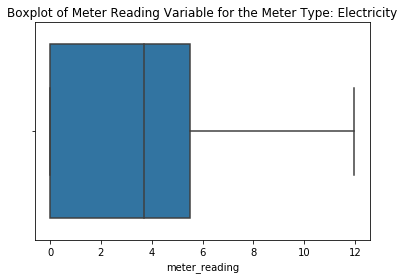

In [42]:
sns.boxplot(np.log1p(train[train['meter'] == "HotWater"]['meter_reading']))
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity")
# We can see a single value that is way off from the rest. 

Text(0.5, 1.0, 'Boxplot of Meter Reading Variable for the Meter Type: Electricity')

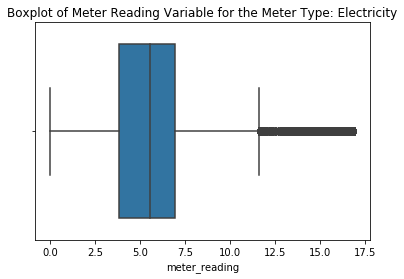

In [43]:
sns.boxplot(np.log1p(train[train['meter'] == "Steam"]['meter_reading']))
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity") 

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Electricity')

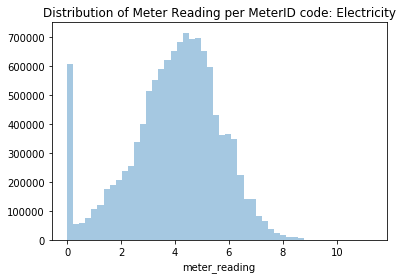

In [44]:
sns.distplot(np.log1p(train[train['meter'] == "Electricity"]['meter_reading']),kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Electricity")

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Chilledwater')

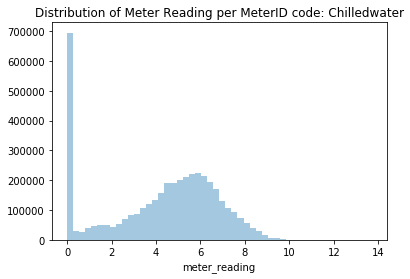

In [45]:
sns.distplot(np.log1p(train[train['meter'] == "ChilledWater"]['meter_reading']),kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Steam')

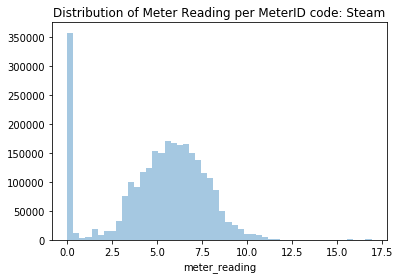

In [46]:
sns.distplot(np.log1p(train[train['meter'] == "Steam"]['meter_reading']),kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Steam")

Text(0.5, 1.0, 'Distribution of Meter Reading per MeterID code: Hotwater')

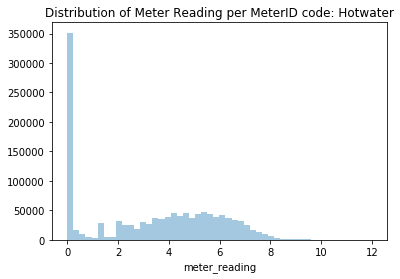

In [47]:
sns.distplot(np.log1p(train[train['meter'] == "HotWater"]['meter_reading']),kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Hotwater")

### Metadata EDA

In [48]:
metadata.info()
# Missing values in year_built and floor_count variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
site_id             1449 non-null uint8
building_id         1449 non-null uint16
primary_use         1449 non-null object
square_feet         1449 non-null float32
year_built          675 non-null float32
floor_count_isNa    1449 non-null uint8
year_built_isNa     1449 non-null uint8
dtypes: float32(2), object(1), uint16(1), uint8(3)
memory usage: 29.8+ KB


In [49]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count_isNa,year_built_isNa
0,0,0,Education,7432.00000,2008.00000,1,0
1,0,1,Education,2720.00000,2004.00000,1,0
2,0,2,Education,5376.00000,1991.00000,1,0
3,0,3,Education,23685.00000,2002.00000,1,0
4,0,4,Education,116607.00000,1975.00000,1,0


In [50]:
cols = ['site_id','primary_use','building_id','year_built']
for col in cols:
    print ("Number of Unique Values in the {} column are:".format(col),metadata[col].nunique())

Number of Unique Values in the site_id column are: 16
Number of Unique Values in the primary_use column are: 16
Number of Unique Values in the building_id column are: 1449
Number of Unique Values in the year_built column are: 116


In [51]:
cols = ['site_id','primary_use','year_built']
for col in cols:
    print ("Unique Values in the {} column are:".format(col),metadata[col].unique())
    print ("\n")

Unique Values in the site_id column are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Unique Values in the primary_use column are: ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


Unique Values in the year_built column are: [2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1

In [52]:
trace1 = go.Bar(x=metadata['site_id'].unique(),y=metadata['site_id'].value_counts().values,marker=dict(color="rgb(55, 83, 109)"))
data=[trace1]
layout = go.Layout(title='Countplot of site_id variable',xaxis=dict(title='site_id'),yaxis=dict(title='Count'),hovermode='closest')
figure = go.Figure(data=data,layout=layout)
iplot(figure)

In [53]:
trace1 = go.Bar(x=metadata['primary_use'].unique(),y=metadata['primary_use'].value_counts().values,marker=dict(color="rgb(55, 83, 109)"))
data=[trace1]
layout = go.Layout(title='Countplot of primary_use variable',xaxis=dict(title='primary_use'),yaxis=dict(title='Count'),hovermode='closest')
figure = go.Figure(data=data,layout=layout)
iplot(figure)
# Education, Office, Entertainment/Public Assembly, Public Services, Lodging/Residential form the bulk of Primary Use

In [54]:
metadata['primary_use'].value_counts(normalize=True)
# Since there are a lot of categories which form a meager percentage of the whole , it makes sense to combine them. 

Education                       0.37888
Office                          0.19255
Entertainment/public assembly   0.12698
Public services                 0.10766
Lodging/residential             0.10145
Other                           0.01725
Healthcare                      0.01587
Parking                         0.01518
Warehouse/storage               0.00897
Manufacturing/industrial        0.00828
Retail                          0.00759
Services                        0.00690
Technology/science              0.00414
Food sales and service          0.00345
Utility                         0.00276
Religious worship               0.00207
Name: primary_use, dtype: float64

In [55]:
metadata['square_feet'].describe()

count     1449.00000
mean     92111.80469
std     110769.96094
min        283.00000
25%      23012.00000
50%      57673.00000
75%     115676.00000
max     875000.00000
Name: square_feet, dtype: float64

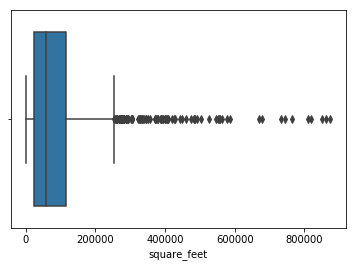

In [56]:
sns.boxplot(metadata['square_feet'])

In [57]:
metadata['square_feet'] = np.log1p(metadata['square_feet'])

Text(0, 0.5, 'Frequency')

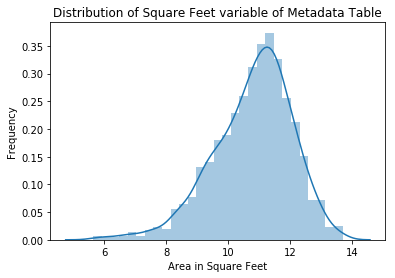

In [58]:
sns.distplot(metadata['square_feet'])
plt.title("Distribution of Square Feet variable of Metadata Table")
plt.xlabel("Area in Square Feet")
plt.ylabel("Frequency")
# Looks like a normal distribution distribution

Text(0.5, 1.0, 'Box Plot of Square Feet Variable')

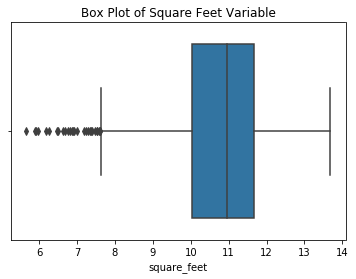

In [59]:
sns.boxplot(metadata['square_feet'])
plt.title("Box Plot of Square Feet Variable")
# There are a few outliers visible

In [60]:
metadata.groupby('primary_use')['square_feet'].agg(['mean','median','count']).sort_values(by='count')
# Parking has the highest average are although the count is less.
# Education has the highest count as can be seen in the countplot above.

,mean,median,count
primary_use,,,
Religious worship,8.87157,9.21044,3
Utility,9.89874,10.02942,4
Food sales and service,10.48744,10.41079,5
Technology/science,10.74879,10.94313,6
Services,11.60188,11.71587,10
Retail,9.80526,10.36303,11
Manufacturing/industrial,10.08105,9.97431,12
Warehouse/storage,10.18141,9.85535,13
Parking,11.86441,12.74981,22


In [61]:
trace1 = go.Bar(x=metadata['year_built'].unique(),y=metadata['year_built'].value_counts().values,marker=dict(color="rgb(55, 83, 109)"))
data=[trace1]
layout = go.Layout(title='Countplot of year_built variable',xaxis=dict(title='year_built'),yaxis=dict(title='Count'),hovermode='closest')
figure = go.Figure(data=data,layout=layout)
iplot(figure)

In [62]:
metadata.groupby('primary_use')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

,count,mean,median
primary_use,,,
Religious worship,3,8.87157,9.21044
Utility,4,9.89874,10.02942
Food sales and service,5,10.48744,10.41079
Technology/science,6,10.74879,10.94313
Services,10,11.60188,11.71587
Retail,11,9.80526,10.36303
Manufacturing/industrial,12,10.08105,9.97431
Warehouse/storage,13,10.18141,9.85535
Parking,22,11.86441,12.74981


In [63]:
metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count_isNa,year_built_isNa
0,0,0,Education,8.91368,2008.00000,1,0
1,0,1,Education,7.90875,2004.00000,1,0
2,0,2,Education,8.58989,1991.00000,1,0
3,0,3,Education,10.07264,2002.00000,1,0
4,0,4,Education,11.66657,1975.00000,1,0


In [64]:
metadata['year_built'].fillna(1976, inplace=True)
metadata['year_built'] = metadata['year_built'].astype('int16')

### Weather Data (Train)

In [65]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.00000,6.00000,20.00000,nan,1019.70000,0.00000,0.00000
1,0,2016-01-01 01:00:00,24.40000,nan,21.10000,-1.00000,1020.20000,70.00000,1.50000
2,0,2016-01-01 02:00:00,22.80000,2.00000,21.10000,0.00000,1020.20000,0.00000,0.00000
3,0,2016-01-01 03:00:00,21.10000,2.00000,20.60000,0.00000,1020.10000,0.00000,0.00000
4,0,2016-01-01 04:00:00,20.00000,2.00000,20.00000,-1.00000,1020.00000,250.00000,2.60000


In [66]:
weather_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null uint8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), uint8(1)
memory usage: 8.7 MB


In [67]:
weather_train.isna().sum()/len(weather_train)

site_id              0.00000
timestamp            0.00000
air_temperature      0.00039
cloud_coverage       0.49490
dew_temperature      0.00081
precip_depth_1_hr    0.35979
sea_level_pressure   0.07597
wind_direction       0.04484
wind_speed           0.00217
dtype: float64

In [68]:
weather_train[['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']].describe()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
count,139718.00000,70600.00000,139660.00000,89484.00000,129155.00000,139469.00000
mean,14.41811,2.14931,7.35016,0.98305,1016.15804,3.56053
std,10.62660,2.59915,9.79023,8.46368,7.62968,2.33587
min,-28.90000,0.00000,-35.00000,-1.00000,968.20000,0.00000
25%,7.20000,0.00000,0.60000,0.00000,1011.80000,2.10000
50%,15.00000,2.00000,8.30000,0.00000,1016.40000,3.10000
75%,22.20000,4.00000,14.40000,0.00000,1020.80000,5.00000
max,47.20000,9.00000,26.10000,343.00000,1045.50000,19.00000


1. Missing values in air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_speed variables
2. There are negative values in air_temperature, dew_temperature and precip_depth_1_hr variables.
3. Looks like there are outliers in precip_depth_1_hr variable (can be guessed from Max value).
4. min value of wind_speed as 0 does not make any sense.

In [69]:
weather_train['timestamp'].describe()
# This data is from 1st Jan to 31st Dec 2016, similar to the timestamp of the training data

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

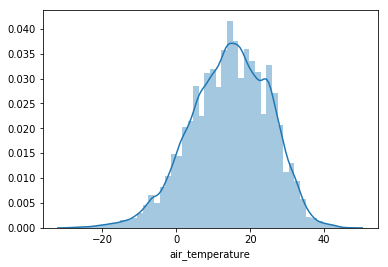

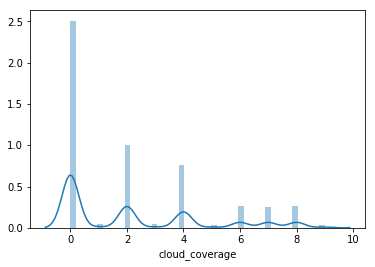

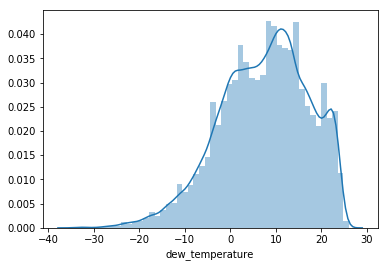

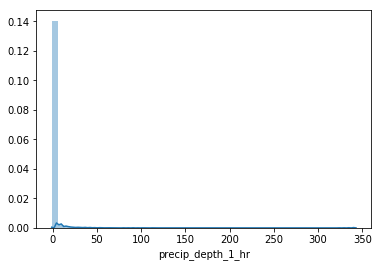

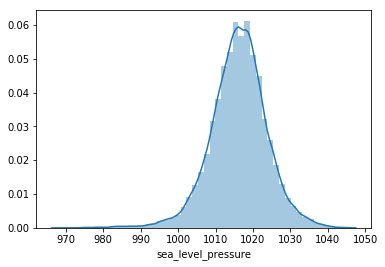

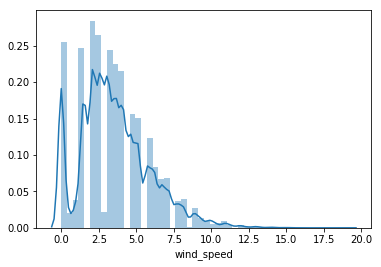

In [70]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())

1. Distribution of sea_level_pressure looks like a normal distribution.
2. Lot of 0 values in precip_depth_1_hr variable.
3. Wind_Speed distribution looks like positively skewed.
4. Dew Temperature looks like a Negatively skewed distribution.
5. Cloud_Coverage takes distinct values unlike these other variables.

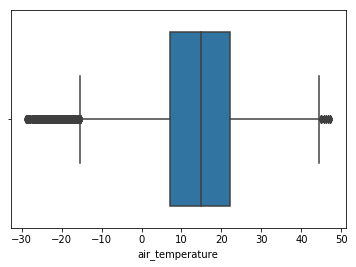

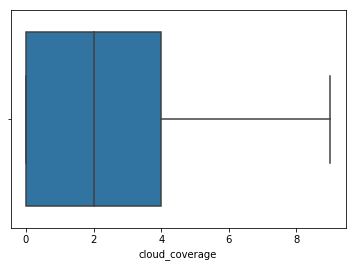

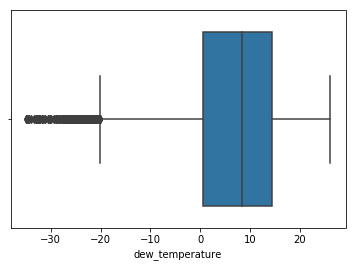

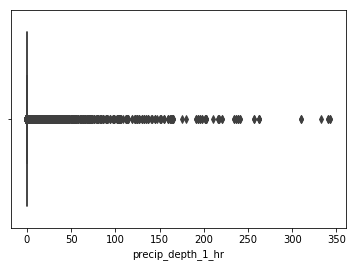

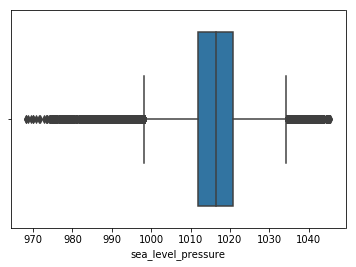

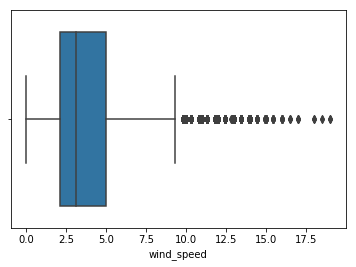

In [71]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.boxplot(weather_train[col].dropna())

### Weather_Test data

In [72]:
weather_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null uint8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: datetime64[ns](1), float64(7), uint8(1)
memory usage: 17.2 MB


In [73]:
weather_test['timestamp'].describe()
# The time duration is similar to the test dataset.

count                  277243
unique                  17520
top       2018-12-06 13:00:00
freq                       16
first     2017-01-01 00:00:00
last      2018-12-31 23:00:00
Name: timestamp, dtype: object

In [74]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    return weather_df

In [75]:
weather_train = fill_weather_dataset(weather_train)
weather_test = fill_weather_dataset(weather_test)

In [76]:
for df in [weather_train,weather_test]:
    df['air_temperature'] = df['air_temperature'].astype('float32')
    df['cloud_coverage'] = df['cloud_coverage'].astype('float16')
    df['dew_temperature'] = df['dew_temperature'].astype('float16')
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
    df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
    df['wind_direction'] = df['wind_direction'].astype('float32')
    df['wind_speed'] = df['wind_speed'].astype('float16')

### Merging Data

In [77]:
%%time
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 14)
Testing Data Shape (41697600, 13)
CPU times: user 14.9 s, sys: 11.9 s, total: 26.8 s
Wall time: 23.9 s


0

In [78]:
%%time
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data Shape {}".format(train.shape))
print ("Testing Data Shape {}".format(test.shape))
gc.collect()

Training Data Shape (20216100, 21)
Testing Data Shape (41697600, 20)
CPU times: user 17.9 s, sys: 15.3 s, total: 33.1 s
Wall time: 28.9 s


0

In [79]:
for df in [train,test]:
    df['square_feet'] = df['square_feet'].astype('float16')
    df['Age'] = df['timestamp'].dt.year - df['year_built']
    df['Age_isNa'] = df['year_built_isNa']

In [80]:
train.drop('year_built_isNa',axis=1,inplace=True)
test.drop('year_built_isNa',axis=1,inplace=True)

In [81]:
# As per the discussion in the following thread, https://www.kaggle.com/c/ashrae-energy-prediction/discussion/117083, there is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them
idx_to_drop = list((train[(train['site_id'] == 0) & (train['timestamp'] < "2016-05-21 00:00:00")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

392857


In [82]:
# dropping all the electricity meter readings that are 0, after considering them as anomalies.
idx_to_drop = list(train[(train['meter'] == "Electricity") & (train['meter_reading'] == 0)].index)
print(len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

185592


In [83]:
idx_to_drop = list((train[(train['building_id']==1099)&(train['meter_reading'] > 30000)&(train['meter'] == "Steam")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

3351


In [84]:
# Converting the dependent variable to logarithmic scale
train['meter_reading'] = np.log1p(train['meter_reading'])

In [85]:
%%time
mean_meter_reading_per_building = train.groupby('building_id')['meter_reading'].mean()
train['mean_meter_reading_per_building'] = train['building_id'].map(mean_meter_reading_per_building)
median_meter_reading_per_building = train.groupby('building_id')['meter_reading'].median()
train['median_meter_reading_per_building'] = train['building_id'].map(median_meter_reading_per_building)
std_meter_reading_per_building = train.groupby('building_id')['meter_reading'].std()
train['std_meter_reading_per_building'] = train['building_id'].map(std_meter_reading_per_building)

mean_meter_reading_per_dayofweek = train.groupby('DayOfWeek')['meter_reading'].mean()
train['mean_meter_reading_per_dayofweek'] = train['DayOfWeek'].map(mean_meter_reading_per_dayofweek)
median_meter_reading_per_dayofweek = train.groupby('DayOfWeek')['meter_reading'].median()
train['median_meter_reading_per_dayofweek'] = train['DayOfWeek'].map(median_meter_reading_per_dayofweek)
std_meter_reading_per_dayofweek = train.groupby('DayOfWeek')['meter_reading'].std()
train['std_meter_reading_per_dayofweek'] = train['DayOfWeek'].map(std_meter_reading_per_dayofweek)


mean_meter_reading_per_meter = train.groupby('meter')['meter_reading'].mean()
train['mean_meter_reading_per_meter'] = train['meter'].map(mean_meter_reading_per_meter)
median_meter_reading_per_meter = train.groupby('meter')['meter_reading'].median()
train['median_meter_reading_per_meter'] = train['meter'].map(median_meter_reading_per_meter)
std_meter_reading_per_meter = train.groupby('meter')['meter_reading'].std()
train['std_meter_reading_per_meter'] = train['meter'].map(std_meter_reading_per_meter)


mean_meter_reading_per_month = train.groupby('Month')['meter_reading'].mean()
train['mean_meter_reading_per_month'] = train['Month'].map(mean_meter_reading_per_month)
median_meter_reading_per_month = train.groupby('Month')['meter_reading'].median()
train['median_meter_reading_per_month'] = train['Month'].map(median_meter_reading_per_month)
std_meter_reading_per_month = train.groupby('Month')['meter_reading'].std()
train['std_meter_reading_per_month'] = train['Month'].map(std_meter_reading_per_month)


test['mean_meter_reading_per_building'] = test['building_id'].map(mean_meter_reading_per_building)
test['median_meter_reading_per_building'] = test['building_id'].map(median_meter_reading_per_building)
test['std_meter_reading_per_building'] = test['building_id'].map(std_meter_reading_per_building)

test['mean_meter_reading_per_dayofweek'] = test['DayOfWeek'].map(mean_meter_reading_per_dayofweek)
test['median_meter_reading_per_dayofweek'] = test['DayOfWeek'].map(median_meter_reading_per_dayofweek)
test['std_meter_reading_per_dayofweek'] = test['DayOfWeek'].map(std_meter_reading_per_dayofweek)

test['mean_meter_reading_per_meter'] = test['meter'].map(mean_meter_reading_per_meter)
test['median_meter_reading_per_meter'] = test['meter'].map(median_meter_reading_per_meter)
test['std_meter_reading_per_meter'] = test['meter'].map(std_meter_reading_per_meter)

test['mean_meter_reading_per_month'] = test['Month'].map(mean_meter_reading_per_month)
test['median_meter_reading_per_month'] = test['Month'].map(median_meter_reading_per_month)
test['std_meter_reading_per_month'] = test['Month'].map(std_meter_reading_per_month)

CPU times: user 39.5 s, sys: 22.4 s, total: 1min 1s
Wall time: 53.5 s


In [86]:
%%time
for df in [train, test]:
    df['mean_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['median_meter_reading_per_building'] = df['mean_meter_reading_per_building'].astype("float16")
    df['std_meter_reading_per_building'] = df['std_meter_reading_per_building'].astype("float16")
    
    df['mean_meter_reading_per_meter'] = df['mean_meter_reading_per_meter'].astype("float16")
    df['median_meter_reading_per_meter'] = df['median_meter_reading_per_meter'].astype("float16")
    df['std_meter_reading_per_meter'] = df['std_meter_reading_per_meter'].astype("float16")
    
    df['mean_meter_reading_per_dayofweek'] = df['mean_meter_reading_per_dayofweek'].astype("float16")
    df['median_meter_reading_per_dayofweek'] = df['median_meter_reading_per_dayofweek'].astype("float16")
    df['std_meter_reading_per_dayofweek'] = df['std_meter_reading_per_dayofweek'].astype("float16")
    
    df['mean_meter_reading_per_month'] = df['mean_meter_reading_per_month'].astype("float16")
    df['median_meter_reading_per_month'] = df['median_meter_reading_per_month'].astype("float16")
    df['std_meter_reading_per_month'] = df['std_meter_reading_per_month'].astype("float16")
    df['Age'] = df['Age'].astype('uint8')
gc.collect()

CPU times: user 5.3 s, sys: 7.25 s, total: 12.6 s
Wall time: 8.11 s


0

In [87]:
train.drop(['timestamp','year_built'],axis=1,inplace=True)
test.drop(['timestamp','year_built'],axis=1,inplace=True)

In [88]:
print (train.shape, test.shape)

(19634300, 32) (41697600, 31)


In [89]:
%%time
le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

CPU times: user 45.2 s, sys: 1.59 s, total: 46.7 s
Wall time: 46.5 s


In [90]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

CPU times: user 49.6 s, sys: 6.38 s, total: 56 s
Wall time: 55.7 s


,building_id,meter,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,floor_count_isNa,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,Age,Age_isNa,mean_meter_reading_per_building,median_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_per_dayofweek,median_meter_reading_per_dayofweek,std_meter_reading_per_dayofweek,mean_meter_reading_per_meter,median_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_month,median_meter_reading_per_month,std_meter_reading_per_month
building_id,1.00000,0.15473,0.08498,0.02306,0.00366,0.00023,0.00010,0.98030,0.06906,0.15811,0.16197,0.31440,0.14325,0.09771,0.08871,0.08926,0.04686,0.00836,0.03604,0.42164,0.12365,0.12365,0.34774,0.00050,0.00048,0.00048,0.25914,0.31178,0.26123,0.01696,0.01798,0.00004
meter,0.15473,1.00000,0.09882,0.00451,0.00026,0.00036,0.00034,0.15063,0.01361,0.07066,0.03262,0.05768,0.03705,0.00781,0.01668,0.02405,0.00074,0.00811,0.00068,0.07018,0.08717,0.08717,0.11194,0.00031,0.00031,0.00033,0.50542,0.40133,0.22233,0.00173,0.00172,0.00146
meter_reading,0.08498,0.09882,1.00000,0.01320,0.00310,0.02757,0.03513,0.10446,0.06104,0.46145,0.15638,0.00805,0.01945,0.02958,0.01411,0.01237,0.01751,0.03139,0.11769,0.01418,0.68712,0.68712,0.06417,0.03470,0.03469,0.03319,0.19588,0.17979,0.05550,0.03994,0.03868,0.01392
Month,0.02306,0.00451,0.01320,1.00000,0.01216,0.00324,0.00011,0.01919,0.00307,0.00533,0.01871,0.17510,0.01706,0.25419,0.03409,0.11626,0.02896,0.06753,0.02102,0.04598,0.02175,0.02175,0.01248,0.00744,0.00752,0.00752,0.00376,0.00183,0.00489,0.33151,0.32681,0.07466
DayOfMonth,0.00366,0.00026,0.00310,0.01216,1.00000,0.00364,0.00055,0.00339,0.00066,0.00144,0.00010,0.02203,0.00399,0.02076,0.01566,0.01047,0.01716,0.00884,0.00269,0.00143,0.00152,0.00152,0.00155,0.00776,0.00770,0.00976,0.00031,0.00097,0.00180,0.00534,0.00628,0.00404


In [91]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,building_id,meter,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,floor_count_isNa,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,Age,Age_isNa,mean_meter_reading_per_building,median_meter_reading_per_building,std_meter_reading_per_building,mean_meter_reading_per_dayofweek,median_meter_reading_per_dayofweek,std_meter_reading_per_dayofweek,mean_meter_reading_per_meter,median_meter_reading_per_meter,std_meter_reading_per_meter,mean_meter_reading_per_month,median_meter_reading_per_month,std_meter_reading_per_month
building_id,nan,0.15473,0.08498,0.02306,0.00366,0.00023,0.00010,0.98030,0.06906,0.15811,0.16197,0.31440,0.14325,0.09771,0.08871,0.08926,0.04686,0.00836,0.03604,0.42164,0.12365,0.12365,0.34774,0.00050,0.00048,0.00048,0.25914,0.31178,0.26123,0.01696,0.01798,0.00004
meter,nan,nan,0.09882,0.00451,0.00026,0.00036,0.00034,0.15063,0.01361,0.07066,0.03262,0.05768,0.03705,0.00781,0.01668,0.02405,0.00074,0.00811,0.00068,0.07018,0.08717,0.08717,0.11194,0.00031,0.00031,0.00033,0.50542,0.40133,0.22233,0.00173,0.00172,0.00146
meter_reading,nan,nan,nan,0.01320,0.00310,0.02757,0.03513,0.10446,0.06104,0.46145,0.15638,0.00805,0.01945,0.02958,0.01411,0.01237,0.01751,0.03139,0.11769,0.01418,0.68712,0.68712,0.06417,0.03470,0.03469,0.03319,0.19588,0.17979,0.05550,0.03994,0.03868,0.01392
Month,nan,nan,nan,nan,0.01216,0.00324,0.00011,0.01919,0.00307,0.00533,0.01871,0.17510,0.01706,0.25419,0.03409,0.11626,0.02896,0.06753,0.02102,0.04598,0.02175,0.02175,0.01248,0.00744,0.00752,0.00752,0.00376,0.00183,0.00489,0.33151,0.32681,0.07466
DayOfMonth,nan,nan,nan,nan,nan,0.00364,0.00055,0.00339,0.00066,0.00144,0.00010,0.02203,0.00399,0.02076,0.01566,0.01047,0.01716,0.00884,0.00269,0.00143,0.00152,0.00152,0.00155,0.00776,0.00770,0.00976,0.00031,0.00097,0.00180,0.00534,0.00628,0.00404
DayOfWeek,nan,nan,nan,nan,nan,nan,0.00016,0.00017,0.00013,0.00034,0.00004,0.00639,0.00366,0.00357,0.00033,0.00283,0.00806,0.00225,0.00005,0.00004,0.00031,0.00031,0.00013,0.79795,0.80592,0.67833,0.00004,0.00016,0.00020,0.01338,0.01587,0.03051
Hour,nan,nan,nan,nan,nan,nan,nan,0.00012,0.00008,0.00004,0.00018,0.11549,0.03178,0.00077,0.00325,0.00408,0.04639,0.14677,0.00011,0.00018,0.00009,0.00009,0.00007,0.00007,0.00007,0.00019,0.00014,0.00001,0.00021,0.00038,0.00035,0.00024
site_id,nan,nan,nan,nan,nan,nan,nan,nan,0.08756,0.17696,0.23520,0.30643,0.10907,0.12471,0.08746,0.07053,0.04964,0.01610,0.00715,0.42912,0.15199,0.15199,0.39174,0.00036,0.00034,0.00033,0.24313,0.31225,0.29494,0.01354,0.01471,0.00047
primary_use,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.17010,0.08881,0.04503,0.13157,0.01519,0.01937,0.03700,0.02542,0.05305,0.07030,0.15097,0.08886,0.08886,0.12308,0.00003,0.00002,0.00011,0.00408,0.03735,0.08672,0.00213,0.00218,0.00063
square_feet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.16608,0.03499,0.08616,0.06185,0.02761,0.03080,0.02190,0.05224,0.07544,0.01015,0.67157,0.67157,0.37216,0.00031,0.00033,0.00016,0.10722,0.18920,0.25701,0.00260,0.00273,0.00172


In [92]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

There are 6 columns to remove.
Following columns can be dropped ['site_id', 'median_meter_reading_per_building', 'median_meter_reading_per_dayofweek', 'std_meter_reading_per_dayofweek', 'median_meter_reading_per_meter', 'median_meter_reading_per_month']


In [93]:
train.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

In [94]:
y = train['meter_reading']
train.drop('meter_reading',axis=1,inplace=True)

In [95]:
categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek','DayOfMonth','floor_count_isNa']

In [96]:
params = {'feature_fraction': 0.8,
          'bagging_fraction': 0.5,
          "bagging_freq": 5,
          'objective': 'regression',
          'max_depth': 11,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
          'random_state': 47,
          "num_leaves": 31}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(train):
    train_features = train.iloc[train_index]
    train_target = y.iloc[train_index]
    
    test_features = train.iloc[test_index]
    test_target = y.iloc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_cols, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_cols, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    models.append(model)
    gc.collect()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.983017	valid_1's rmse: 1.1694
[200]	training's rmse: 0.863708	valid_1's rmse: 1.09562
[300]	training's rmse: 0.826407	valid_1's rmse: 1.07795
[400]	training's rmse: 0.806534	valid_1's rmse: 1.07288
[500]	training's rmse: 0.785422	valid_1's rmse: 1.06853
[600]	training's rmse: 0.770526	valid_1's rmse: 1.06349
[700]	training's rmse: 0.756917	valid_1's rmse: 1.0608
[800]	training's rmse: 0.746007	valid_1's rmse: 1.05873
[900]	training's rmse: 0.735461	valid_1's rmse: 1.05558
[1000]	training's rmse: 0.726766	valid_1's rmse: 1.05416
[1100]	training's rmse: 0.718056	valid_1's rmse: 1.05139
[1200]	training's rmse: 0.709724	valid_1's rmse: 1.05023
[1300]	training's rmse: 0.702503	valid_1's rmse: 1.04871
[1400]	training's rmse: 0.69569	valid_1's rmse: 1.04743
[1500]	training's rmse: 0.689502	valid_1's rmse: 1.04446
[1600]	training's rmse: 0.684131	valid_1's rmse: 1.04297
[1700]	training's rmse: 0.678992	valid

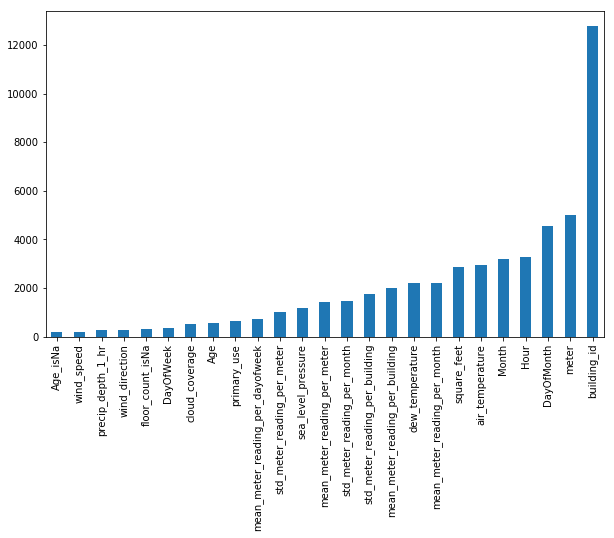

In [97]:
ser1 = pd.DataFrame(models[0].feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser1['Importance'].plot(kind='bar',figsize=(10,6))

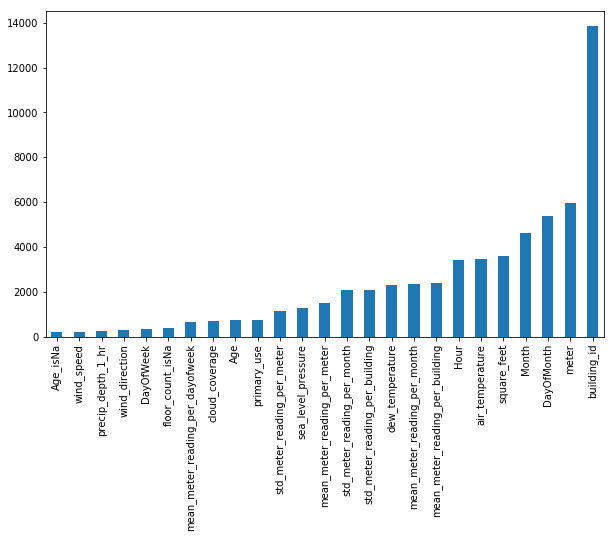

In [98]:
ser2 = pd.DataFrame(models[1].feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser2['Importance'].plot(kind='bar',figsize=(10,6))

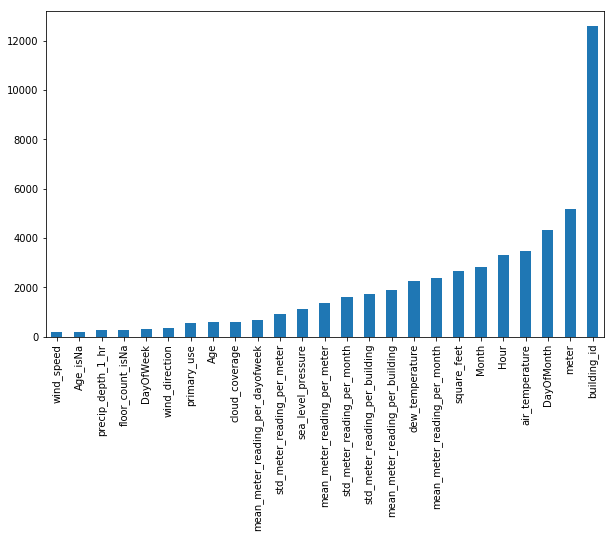

In [99]:
ser3 = pd.DataFrame(models[2].feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
ser3['Importance'].plot(kind='bar',figsize=(10,6))

In [100]:
del train_features, train_target, test_features, test_target, d_training, d_test, weather_train, weather_test, metadata

In [101]:
stepsize = 500000
results = np.zeros(test.shape[0])
for model in models:
  predictions = []
  for i in range(0, test.shape[0], stepsize):
    predictions.append(np.expm1(model.predict(test.loc[i:i+stepsize-1,:], num_iteration=model.best_iteration)))
  results += (1 / len(models)) * np.concatenate(predictions, axis=0)
  del(model)

In [102]:
%%time
Submission['meter_reading'] = results
Submission['meter_reading'].clip(lower=0,upper=None,inplace=True)
Submission.to_csv("Normal.csv",index=None)

CPU times: user 4min 16s, sys: 4.05 s, total: 4min 20s
Wall time: 4min 22s


In [103]:
Submission.head(20)

,row_id,meter_reading
0,0,160.09612
1,1,74.80849
2,2,8.19067
3,3,215.13541
4,4,1214.42855
5,5,13.19571
6,6,97.07784
7,7,436.53534
8,8,389.95310
9,9,315.15955
